In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [84]:
from time import time
from sklearn.metrics import f1_score


In [85]:
data=pd.read_csv('student-data.csv')

In [86]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


Now, after running the above code we have found that the last column is the target column and we have to make the predictions on the passed column only.

Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, n_students.
- The total number of features for each student, n_features.
- The number of those students who passed, n_passed.
- The number of those students who failed, n_failed.
- The graduation rate of the class, grad_rate, in percent (%).

In [87]:
n_students=len(data)
n_features=len(data.columns[0:-1])
n_passed=len(data[data.passed=='yes'])
n_failed=len(data[data.passed=='no'])
grad_rate=float(n_passed)/n_students*100
print("The total number of students in the dataset are:",n_students)
print("The total number of features in the dataset are:",n_features)
print("The total number of students who have passed in the dataset are:",n_passed)
print("The total number of students who have failed in the dataset are:",n_failed)
print("The graduation rate of the students in the dataset are:{:.2f}%".format(grad_rate))

The total number of students in the dataset are: 395
The total number of features in the dataset are: 30
The total number of students who have passed in the dataset are: 265
The total number of students who have failed in the dataset are: 130
The graduation rate of the students in the dataset are:67.09%


In [88]:
passed=pd.value_counts(data['passed'])

In [89]:
print(passed)

yes    265
no     130
Name: passed, dtype: int64


**Identify feature and target columns**

It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.
Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [104]:
features_columns=list(data.columns[0:-1])
target_columns=data.columns[-1]
print("The feature columns are:",features_columns)
print("\nThe target columns are:",target_columns)
X_all=data[features_columns]
y_all=data[target_columns]
print(X_all.head())
print(y_all.head())

The feature columns are: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

The target columns are: passed
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

In [105]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print ("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


**Implementation: Training and Testing Data Split**

So far, we have converted all categorical features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
Randomly shuffle and split the data (X_all, y_all) into training and testing subsets.
Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
Set a random_state for the function(s) you use, if provided.
Store the results in X_train, X_test, y_train, and y_test.
In [5]:

In [106]:
# TODO: Import any additional functionality you may need here
from sklearn.model_selection import train_test_split
# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = x_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
def shuffle_and_split_data(x_all, y_all):
    xtrain, xtest, ytrain, ytest = train_test_split(x_all, y_all, test_size=0.2405, random_state = 42)
    return xtrain, xtest, ytrain, ytest

xtrain, xtest, ytrain, ytest = shuffle_and_split_data(x_all, y_all)

X_train = xtrain
X_test = xtest
y_train = ytrain
y_test = ytest


# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 300 samples.
Testing set has 95 samples.


**Training and Evaluating Models**

In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in scikit-learn. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F1 score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F1 score on the training set, and F1 score on the testing set.
The following supervised learning models are currently available in scikit-learn that you may choose from:
Gaussian Naive Bayes (GaussianNB)
Decision Trees
Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
K-Nearest Neighbors (KNeighbors)
Stochastic Gradient Descent (SGDC)
Support Vector Machines (SVM)
Logistic Regression

**Question 2 - Model Application**
List three supervised learning models that are appropriate for this problem. For each model chosen
Describe one real-world application in industry where the model can be applied. (You may need to do a small bit of research for this — give references!)
What are the strengths of the model; when does it perform well?
What are the weaknesses of the model; when does it perform poorly?
What makes this model a good candidate for the problem, given what you know about the data?
Answer: The three supervised models that are appropriate for this problem are : -- Logistic Regression -- Support Vector Machines(SVM) -- Ensemble Methods(RandomForest)

**1) Logistic Regression :**

1.1) Logistic Regression can be used to predict for 'Credit Risk Analysis'. It can be used to predict for which party a person is going to vote for.It can even be used to predict wheter a student will get an admission to a college or not based on a number of criteria.
(Sources:https://smartdrill.com/logistic-regression.html ,Quora, Google)

1.2) Advantages of Logistic Regression :
You can use more than one explanatory variable (dependent variable) and those can either be dichotomous, ordinal, or continuous.
It helps to remove the 'confounding effect'.
It does not need a linear relationship between the dependent and independent variables. Logistic regression can handle all sorts of relationships, because it applies a non-linear log transformation to the predicted odds ratio.
The independent variables do not need to be metric (interval or ratio scaled).
Logistic Regression performs well when features are roughly linear and the problem is likely to be linearly separable

1.3) Disadvantages of Logistic Regression :
Binary logistic regression requires the dependent variable to be binary and ordinal logistic regression requires the dependent variable to be ordinal.
Linearity test is required on a non-binomial dependent variable before including it in the model.
It combines both binomial and normal distribution which can cause problems sometimes.
Logistic Regression performs poorly if the features are highly correlated.

1.4) Logistic Regression can be applied to our data as it can be seen thet the features are not so highly correlated. Also, the outcome is a binomial distribution

In [107]:
x_all.corr().head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
age,1.000000,-0.163658,-0.163438,0.070641,-0.004140,0.243665,0.053940,0.016434,0.126964,0.131125,...,0.103063,-0.103063,0.086632,-0.086632,0.209081,-0.209081,0.112094,-0.112094,-0.164669,0.164669
Medu,-0.163658,1.000000,0.623455,-0.171639,0.064944,-0.236680,-0.003914,0.030891,0.064094,0.019834,...,-0.108277,0.108277,-0.193263,0.193263,-0.168845,0.168845,-0.201463,0.201463,-0.039681,0.039681
Fedu,-0.163438,0.623455,1.000000,-0.158194,-0.009175,-0.250408,-0.001370,-0.012846,0.043105,0.002386,...,-0.112643,0.112643,-0.157177,0.157177,-0.174566,0.174566,-0.127507,0.127507,-0.015602,0.015602
traveltime,0.070641,-0.171639,-0.158194,1.000000,-0.100909,0.092239,-0.016808,-0.017025,0.028540,0.138325,...,0.007766,-0.007766,0.033338,-0.033338,0.083508,-0.083508,0.111302,-0.111302,-0.021962,0.021962
studytime,-0.004140,0.064944,-0.009175,-0.100909,1.000000,-0.173563,0.039731,-0.143198,-0.063904,-0.196019,...,-0.089877,0.089877,-0.081325,0.081325,-0.175081,0.175081,-0.059422,0.059422,-0.053285,0.053285


**2) Support Vector Machines(SVM) :**

2.1) SVM is used in financial industries in financial time series forecasting. (Source : http://www.svms.org/finance/)

2.2) Advantages of SVM:
It is a great classsification algorithm that gives a better decision boundary, a boundary with a large margin. This can be seen in the fig. below. alt text
SVM even works well to find a decision boundary if the data is not linearly separable(i.e. can't be fitted with a straight line). This is shown below. alt text SVM provides us the choice of choosing a non-linear kernel too
Less Overfiting in nature.
Robust to noise
SVM performs well if there is a two-class problem with balanced data set with almost zero or little noise.
It uses a subset of training points in the decision function (called support vectors), so it is also memory efficient

2.3) Disadvantages of SVM:
SVMs do not perform well on highly skewed/imbalanced data sets. These are training data sets in which the number of samples that fall in one of the classes far outnumber those that are a member of the other class.
SVMs are also not a good option specially if you have multiple classes. alt text
SVM is not good for incremental learning
SVM is not desirable for very large datasets. Also, it performs very poorly if the number of features are greater in number than the number of training examples.

2.4) SVM is well suited for our dataset because there are only two classes of outcome. Also, the number of features are not so large as well as the training set is relatively small, hence SVM is a good choice.
**3) Ensemble Methods (Random Forest)**

3.1) Application in industry : Random Forest algorithm is widely used in finance as well as in Machine Fault diagnosis (source: http://link.springer.com/chapter/10.1007%2F978-1-84628-814-2_82 , http://www.scientific.net/AMM.740.947)

3.2) Advantages of Ensembles(Random Forest) :
They do not expect linear features or even features that interact linearly.
These algorithms handle very well high dimensional spaces as well as large number of training examples.
RF generates an internal unbiased estimate of the generalization error as the forest building progresses.
RF has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.
Random Forests attempts to mitigate the problems of high variance and high bias by averaging to find a natural balance between the two extremes.
alt text
RF perfroms well if the datset is class-balanced i.e.no class contains significantly more samples than the other.

3.3) Disadvantages of Ensembles(Random Forest):
RF are prone to 'Overfiting' if the dataset is noisy
As the dataset grows, large number of trees are required, hence complexity of the model increases.
For data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels. Therefore, the variable importance scores from random forest are not reliable for this type of data.
RF performs poorly when the number of dimensions is tooo high as compared to the number of training examples. Also, it is not the best suited algorihm when dataset contain categorical features at different levels as it will overfit in this case.

*Setup*
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
train_classifier - takes as input a classifier and training data and fits the classifier to the data.
predict_labels - takes as input a fit classifier, features, and a target labeling and makes predictions using the F1 score.
train_predict - takes as input a classifier, and the training and testing data, and performs train_clasifier and predict_labels.
This function will report the F1 score for both the training and testing data separately.


In [108]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test)))


In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state=42)
clf_B = SVC(random_state=33)
clf_C = RandomForestClassifier(random_state =42)

# TODO: Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train
y_train_300 = y_train

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
print('--- Trianing size 100 --')
train_predict(clf_A, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)
print (' ')

print ('--- Training size 200 ---')
train_predict(clf_A, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)
print (' ')

print ('--- Training size 300 --')
train_predict(clf_A, X_train_300, y_train_300, X_test, y_test)
train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)
train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)

--- Trianing size 100 --
Training a LogisticRegression using a training set size of 100. . .
Trained model in 0.0020 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.8613.
Made predictions in 0.0060 seconds.
F1 score for test set: 0.7704.
Training a SVC using a training set size of 100. . .
Trained model in 0.0030 seconds
Made predictions in 0.0070 seconds.
F1 score for training set: 0.8696.
Made predictions in 0.0020 seconds.
F1 score for test set: 0.7746.
Training a RandomForestClassifier using a training set size of 100. . .
Trained model in 0.2300 seconds
Made predictions in 0.0020 seconds.
F1 score for training set: 0.9844.
Made predictions in 0.0030 seconds.
F1 score for test set: 0.7317.
 
--- Training size 200 ---
Training a LogisticRegression using a training set size of 200. . .
Trained model in 0.0030 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.8523.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.7914.
Traini

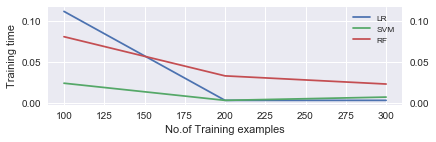

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt


x = [100,200,300]
y = [[0.6880, 0.7248, 0.6977],[0.7442, 0.7101, 0.6508 ],[0.7023, 0.7246, 0.6774]]
plt.xlabel('No.of Training examples')
plt.ylabel('F1 Score(Test)')
plt.plot(x,y )
plt.legend(['LR','SVM','RF'],loc=2,fontsize='small',fancybox=None, frameon=False)
plt.tick_params(labelright=True)

plt.subplot(212)
y = [[0.1120, 0.0240, 0.0810],[0.0030, 0.0030, 0.0330],[0.0030, 0.0070, 0.0230]]
plt.xlabel('No.of Training examples')
plt.ylabel('Training time')
plt.plot(x,y )
plt.legend(['LR','SVM','RF'],loc=1,fontsize='small',fancybox=None, frameon=False)
plt.tick_params(labelright=True)

plt.subplots_adjust(hspace=50.0)
plt.tight_layout()


**Question 3 - Choosing the Best Model**

Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?

*Answer*: 
The model selection is mainly dependent on two things :
Training time : As we can see from the graph shown below, that RandomForest performs poorly in terms of training time. The performance of Logistic Regression as well as Support Vector Machines are very close . Hence we can infer that upto this point (not taking F1 score in consideration yet but talking in terms of cost), thatout of the three models, Logistic Regression or SVM should be considered for model selection

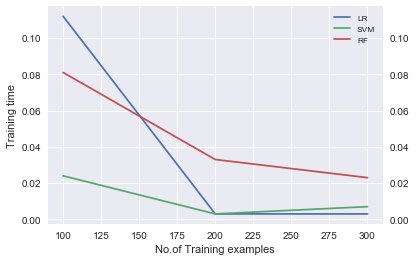

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

x = [100,200,300]
y = [[0.1120, 0.0240, 0.0810],[0.0030, 0.0030, 0.0330],[0.0030, 0.0070, 0.0230]]
plt.xlabel('No.of Training examples')
plt.ylabel('Training time')
plt.plot(x,y )
plt.legend(['LR','SVM','RF'],loc=1,fontsize='small',fancybox=None, frameon=False)
plt.tick_params(labelright=True)

In [114]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {'C' : [0.01, 0.1, 1.0, 10, 100], 'kernel' : ['linear','rbf']}

# TODO: Initialize the classifier
clf = SVC(random_state=42)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print ("Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)))
print ("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)))

Made predictions in 0.0030 seconds.
Tuned model has a training F1 score of 0.8522.
Made predictions in 0.0010 seconds.
Tuned model has a testing F1 score of 0.8000.
